## Segmented Systems

prysm has extremely optimized algorithms for modeling segmented systems.  Its interface is also rather different to its contemporaries.  This deep dive will show how to model a real system, the James Webb Space Telescope (JWST).

As always, we begin with imports:

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from prysm import (
    coordinates,
    geometry,
    segmented,
    polynomials,
    propagation,
    wavelengths
)
from prysm.conf import config

# a convenient short-hand
WF = propagation.Wavefront

From the [Notable Telescopes](../how-tos/Notable-Telescope-Apertures.ipynb) how-to, we borrow the recipe to draw a JWST aperture.  The JWST aperture has 7mm gaps and spans 6.6 meters.  The total span of the array must be at least (5\*1.32 + 4\*0.007) meters, or 6.628 meters.  We require at minimum 3.5mm sample spacing, or at least ~1800 samples.  We'll round that up to 2048.  Now we construct our grid and the geometry of the pupil:

In [2]:
x, y = coordinates.make_xy_grid(2048, diameter=6.628)
dx = x[0,1] - x[0,0]

cha = segmented.CompositeHexagonalAperture(x,y,2,1.32,0.007,exclude=(0,))
m1 = geometry.spider(1, .1, x, y, rotation=-120)
m2 = geometry.spider(1, .1, x, y, rotation=-60)
m3 = geometry.spider(1, .1, x, y, rotation=90)
spider = m1&m2&m3

pupil_mask = cha.amp & spider

We can plot the aperture to make sure its as we expect,

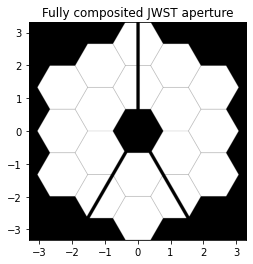

In [3]:
plt.imshow(pupil_mask, origin='lower', cmap='gray', extent=[x.min(), x.max(), y.min(), y.max()])
plt.title('Fully composited JWST aperture');

We'd now like to see a point spread function, so we'll construct a wavefront and propagate it to the focus with Nyquist sampling:

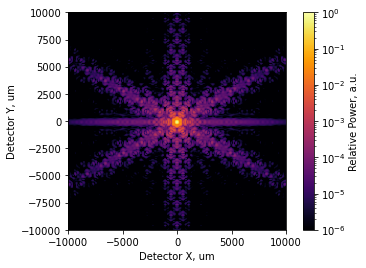

In [4]:
amp = pupil_mask.astype(config.precision)
amp /= amp.sum()  # will result in a PSF that peaks at 1.0 if unaberrated, see radiometrically correct modeling

# wvl = LWIR, as JWST is.  NdYAP and NdYAG are ~1um
# dx needs to be in millimeters, but we drew the pupil in meters
w = WF.from_amp_and_phase(amplitude=amp, phase=None, wavelength=wavelengths.CO2, dx=dx*1e3)

# 120 m EFL
coherent_psf = w.focus(efl=120e3, Q=2)
incoherent_psf = coherent_psf.intensity
incoherent_psf.plot2d(xlim=1e4, log=True, clim=(1e-6,1.0), interpolation='bilinear',
    axis_labels=('Detector X, um', 'Detector Y, um'),
    colorbar_label='Relative Power, a.u.');

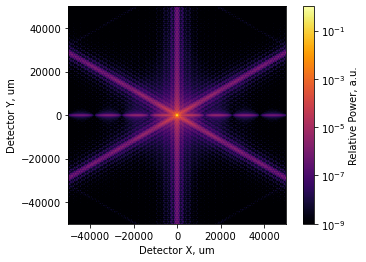

In [5]:
# wider FoV, much wider color range
incoherent_psf.plot2d(xlim=5e4, log=True, clim=(1e-9,1.0), interpolation='bilinear',
    axis_labels=('Detector X, um', 'Detector Y, um'),
    colorbar_label='Relative Power, a.u.');

Now we'd like to see what happens in the center of the PSF if there is a segment phasing error.  We'll consider only piston first.  Any problem of this sort begins by preparing the polynomial basis we will use for each segment.  This is in support of the novel way in which prysm isolates each segment from the others when computing localized errors.  Preparing the polynomial basis hides the not-insiginificant busiwork of book-keeping all the local coordinate grids and 'tiles' of the whole pupil array.  We'll use a Zernike basis in this case, but for piston (or piston+tip-tilt) it really doesn't matter.  For additional details of the very different approach prysm uses for polynomials, see [Ins and Outs of Polynomials](./Ins-and-Outs-of-Polynomials.ipynb).

In [6]:
# just piston (Noll 1)
nms = [polynomials.noll_to_nm(1)]
# the basis sets are returned, silence in Jupyter with a semicolon
cha.prepare_opd_bases(polynomials.zernike_nm_sequence, nms, normalization_radius=1.32);

Normalizing by the flat-to-flat segment diameter will result in some evaluation outside the orthogonal domain for the Zernike polnomials, since the vertex-to-vertex distance is larger than flat-to-flat.  For piston, that doesn't matter at all.  Nowe we'd like to insert some phase error.  In general, problems will perturb all segments, so we prepare an array that will hold the basis coefficients for each mode and each segments.  The second dimension, which polynomial order, will be only of size 1 in this case.  After doing so, we piston one segment by 100 nanometers,

In [7]:
basis_coefs = np.zeros((len(cha.segment_ids), len(nms)), dtype=config.precision)
basis_coefs[8] = 100
phase_map = cha.compose_opd(basis_coefs)

This process is rather fast, taking about 25 milli-seconds for all 18 segments over the 2K x 2K array, a computation rate of about 170 megapixels per second on a desktop CPU.

(Only) when plotting the phase, you may wish to impose the pupil support as a mask for clarity:

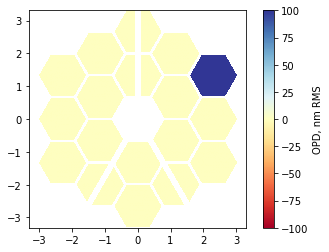

In [8]:
phase_map_plot = phase_map.copy()
phase_map_plot[~pupil_mask] = np.nan
im = plt.imshow(phase_map_plot, origin='lower', cmap='RdYlBu', extent=[x.min(), x.max(), y.min(), y.max()], clim=(-100,100))
plt.colorbar(im, label='OPD, nm RMS');

We can stuff the _non-masked_ phase in our wavefront, and observe the change in the PSF:

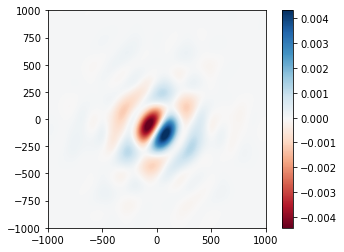

In [9]:
amp = pupil_mask.astype(config.precision)
amp /= amp.sum()  # will result in a PSF that peaks at 1.0 if unaberrated, see radiometrically correct modeling

# wvl = LWIR, as JWST is.  NdYAP and NdYAG are ~1um
# dx needs to be in millimeters, but we drew the pupil in meters
w2 = WF.from_amp_and_phase(amplitude=amp, phase=phase_map, wavelength=wavelengths.CO2, dx=dx*1e3)

# 120 m EFL
coherent_psf2 = w2.focus(efl=120e3, Q=2)
incoherent_psf2 = coherent_psf2.intensity

psf_diff = incoherent_psf2.copy()
psf_diff.data = incoherent_psf2.data - incoherent_psf.data
psf_diff.plot2d(xlim=1e3, cmap='RdBu');

Computing these differences for each segment might be useful to construct a sensitivity matrix for the system.  We can perturb all the segments with random +/- 100 nm pistons just as easily, by changing only a single line of code:

In [10]:
# the reshaping and astype ugliness is, unfortunately, needed.
# the latter only if you ever care about using 32-bit floats
basis_coefs = np.random.uniform(-100, 100, 18).reshape((18, 1)).astype(config.precision)  # one change!
phase_map = cha.compose_opd(basis_coefs)

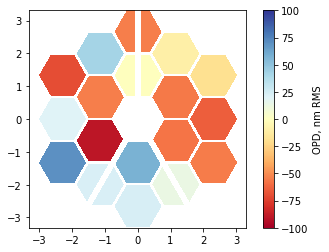

In [11]:
phase_map_plot = phase_map.copy()
phase_map_plot[~pupil_mask] = np.nan
im = plt.imshow(phase_map_plot, origin='lower', cmap='RdYlBu', extent=[x.min(), x.max(), y.min(), y.max()], clim=(-100,100))
plt.colorbar(im, label='OPD, nm RMS');

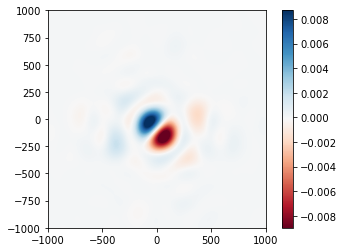

In [12]:
w2 = WF.from_amp_and_phase(amplitude=amp, phase=phase_map, wavelength=wavelengths.CO2, dx=dx*1e3)

# 120 m EFL
coherent_psf2 = w2.focus(efl=120e3, Q=2)
incoherent_psf2 = coherent_psf2.intensity

psf_diff = incoherent_psf2.copy()
psf_diff.data = incoherent_psf2.data - incoherent_psf.data
psf_diff.plot2d(xlim=1e3, cmap='RdBu');

The effect is broadly similar, near the core of the PSF anyway.  We now turn our attention to piston and tip-tilt on a per-segment basis.  First, we must re-generate the basis function with an expansion that extends up to Z3, and then produce an `18x3` array to store the per-segment coefficients:


In [13]:
nms = [polynomials.noll_to_nm(j) for j in (1,2,3)]
cha.prepare_opd_bases(polynomials.zernike_nm_sequence, nms, normalization_radius=1.32);
basis_coefs = np.zeros((len(cha.segment_ids), len(nms)), dtype=config.precision)

We'll crank the pistons up to 500 nm and apply 1 um of segment tip-tilts:

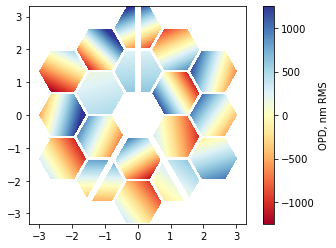

In [14]:
basis_coefs[:, 0] = np.random.uniform(-500, 500, 18)
basis_coefs[:, 1] = np.random.uniform(-1000, 1000, 18)
basis_coefs[:, 2] = np.random.uniform(-1000, 1000, 18)

phase_map = cha.compose_opd(basis_coefs)
phase_map_plot = phase_map.copy()
phase_map_plot[~pupil_mask] = np.nan
im = plt.imshow(phase_map_plot, origin='lower', cmap='RdYlBu', extent=[x.min(), x.max(), y.min(), y.max()], clim=(-1250,1250))
plt.colorbar(im, label='OPD, nm RMS');

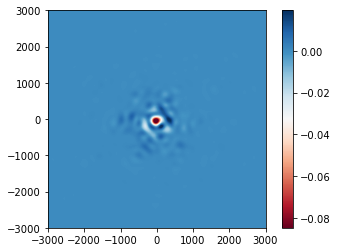

In [15]:
w2 = WF.from_amp_and_phase(amplitude=amp, phase=phase_map, wavelength=wavelengths.CO2, dx=dx*1e3)

coherent_psf2 = w2.focus(efl=120e3, Q=2)
incoherent_psf2 = coherent_psf2.intensity

psf_diff = incoherent_psf2.copy()
psf_diff.data = incoherent_psf2.data - incoherent_psf.data
psf_diff.plot2d(xlim=3e3, cmap='RdBu');

The plotted field of view is somewhat larger now.

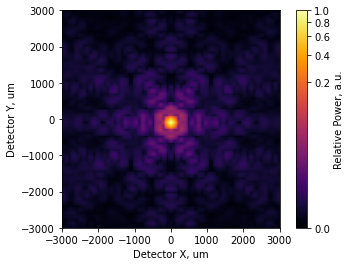

In [16]:
incoherent_psf.plot2d(xlim=3e3, power=1/4, interpolation='bilinear',
    axis_labels=('Detector X, um', 'Detector Y, um'),
    colorbar_label='Relative Power, a.u.');

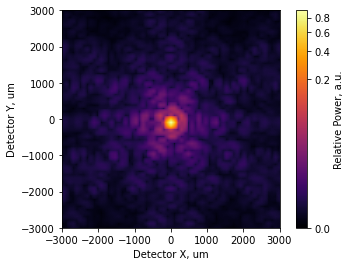

In [17]:
incoherent_psf2.plot2d(xlim=3e3, power=1/4, interpolation='bilinear',
    axis_labels=('Detector X, um', 'Detector Y, um'),
    colorbar_label='Relative Power, a.u.');

We can see the PSF is starting to distort slightly.  We'll now fold in an additional few hundred nanometers of low-order aberration for each segment.  The statistics of the Zernike modes are not realistic, but that does not matter for this tutorial:

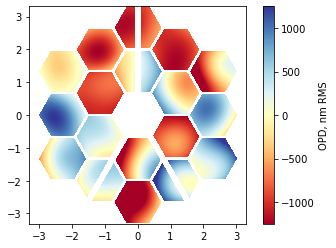

In [18]:
nms = [polynomials.noll_to_nm(j) for j in range(12)]
cha.prepare_opd_bases(polynomials.zernike_nm_sequence, nms, normalization_radius=1.32);
basis_coefs = np.zeros((len(cha.segment_ids), len(nms)), dtype=config.precision)
basis_coefs[:, 0] = np.random.uniform(-500, 500, 18)
basis_coefs[:, 1] = np.random.uniform(-1000, 1000, 18)
basis_coefs[:, 2] = np.random.uniform(-1000, 1000, 18)
basis_coefs[:, 3:] = np.random.uniform(-200, 200, 18*9).reshape((18,9))
# basis_coefs[:, :3] = 0

phase_map = cha.compose_opd(basis_coefs)
phase_map_plot = phase_map.copy()
phase_map_plot[~pupil_mask] = np.nan
im = plt.imshow(phase_map_plot, origin='lower', cmap='RdYlBu', extent=[x.min(), x.max(), y.min(), y.max()], clim=(-1250,1250))
plt.colorbar(im, label='OPD, nm RMS');

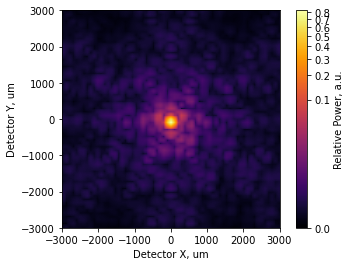

In [19]:
w2 = WF.from_amp_and_phase(amplitude=amp, phase=phase_map, wavelength=wavelengths.CO2, dx=dx*1e3)

coherent_psf2 = w2.focus(efl=120e3, Q=2)
incoherent_psf2 = coherent_psf2.intensity

incoherent_psf2.plot2d(xlim=3e3, power=1/4, interpolation='bilinear',
    axis_labels=('Detector X, um', 'Detector Y, um'),
    colorbar_label='Relative Power, a.u.');

Finally, we can compose the per-segment errors with observatory-scale errors:

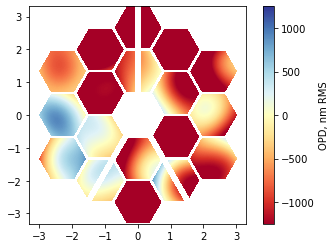

In [20]:
r, t = coordinates.cart_to_polar(x, y)
r /= 6.628  # our old diameter
basis = list(polynomials.zernike_nm_sequence(nms, r, t))
coefs = np.random.rand(len(basis)) * 1000
coefs[:3] = 0  # no observatory level piston, tip, or tilt

wf_map = polynomials.sum_of_2d_modes(basis, coefs)
total_map = phase_map + wf_map
total_map_plot = total_map.copy()
total_map_plot[~pupil_mask] = np.nan
im = plt.imshow(total_map_plot, origin='lower', cmap='RdYlBu', extent=[x.min(), x.max(), y.min(), y.max()], clim=(-1250,1250))
plt.colorbar(im, label='OPD, nm RMS');

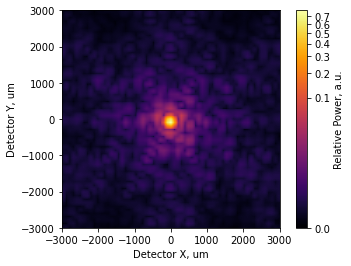

In [21]:
w2 = WF.from_amp_and_phase(amplitude=amp, phase=total_map, wavelength=wavelengths.CO2, dx=dx*1e3)

coherent_psf2 = w2.focus(efl=120e3, Q=2)
incoherent_psf2 = coherent_psf2.intensity

incoherent_psf2.plot2d(xlim=3e3, power=1/4, interpolation='bilinear',
    axis_labels=('Detector X, um', 'Detector Y, um'),
    colorbar_label='Relative Power, a.u.');

we can quickly evaluate the PV and RMS of the pupil phase:

In [22]:
from prysm.util import rms, pv
pv(total_map_plot), rms(total_map_plot)

(3759.3348839350647, 1194.0803948841353)

Given $\lambda = 10.6 \mu m$, this is a little bit worse than the Marechal criteria.


### Wrap-up

In summary, when working with segmented systems:

- rasterize the segments by constructing a composite hexagonal aperture

- use `cha.prepare_opd_bases` and `cha.compose_opd` with `(NSEGMENTS, NMODES)` shaped arrays to evaluate any basis set on a per-segment level

PSD-based wavefront errors and amplitude errors were not covered here.  For amplitude errors, the tools may have the term `opd` in the name, but the returned array could be used to modify amplitude just the same.  For PSD errors, use the interferogram module within prysm to synthesize OPD maps based on a given PSD profile.  It is unlikely that there is a significant difference between the "texture" of the optics (what PSD-based wavefront error is used to simulate) when comparing any two segments.  If there is, consult the source code of `cha.prepare_opd_bases` for how to access the per-segment grids needed in synthesizing, and `cha.compose_opd` for how to insert those localized errors into an array containing all of them.